1. Import Libraries

In [55]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from scipy import stats
import os
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

2.Loading the Dataset

In [58]:
# Load CSV file into a DataFrame
data = pd.read_csv("DDOS comp final.csv")
data.head()

,dt,switch,src,dst,pktcount,bytecount,dur,dur_nsec,tot_dur,flows,...,pktrate,Pairflow,Protocol,port_no,tx_bytes,rx_bytes,tx_kbps,rx_kbps,tot_kbps,label
0,11425,1,10.0.0.1,10.0.0.8,45304,48294064,100,716000000,1.010000e+11,3,...,451,0,UDP,3,143928631,3917,0,0.0,0.0,0
1,11605,1,10.0.0.1,10.0.0.8,126395,134737070,280,734000000,2.810000e+11,2,...,451,0,UDP,4,3842,3520,0,0.0,0.0,0
2,11425,1,10.0.0.2,10.0.0.8,90333,96294978,200,744000000,2.010000e+11,3,...,451,0,UDP,1,3795,1242,0,0.0,0.0,0
3,11425,1,10.0.0.2,10.0.0.8,90333,96294978,200,744000000,2.010000e+11,3,...,451,0,UDP,2,3688,1492,0,0.0,0.0,0
4,11425,1,10.0.0.2,10.0.0.8,90333,96294978,200,744000000,2.010000e+11,3,...,451,0,UDP,3,3413,3665,0,0.0,0.0,0


3.Exploratory Data Analysis (EDA)

In [61]:
# Display dataset info
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104345 entries, 0 to 104344
Data columns (total 23 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   dt           104345 non-null  int64  
 1   switch       104345 non-null  int64  
 2   src          104345 non-null  object 
 3   dst          104345 non-null  object 
 4   pktcount     104345 non-null  int64  
 5   bytecount    104345 non-null  int64  
 6   dur          104345 non-null  int64  
 7   dur_nsec     104345 non-null  int64  
 8   tot_dur      104345 non-null  float64
 9   flows        104345 non-null  int64  
 10  packetins    104345 non-null  int64  
 11  pktperflow   104345 non-null  int64  
 12  byteperflow  104345 non-null  int64  
 13  pktrate      104345 non-null  int64  
 14  Pairflow     104345 non-null  int64  
 15  Protocol     104345 non-null  object 
 16  port_no      104345 non-null  int64  
 17  tx_bytes     104345 non-null  int64  
 18  rx_bytes     104345 non-

In [63]:
# Display unique labels and their counts
print(data.label.unique())
print(data.label.value_counts())

[0 1]
label
0    63561
1    40784
Name: count, dtype: int64


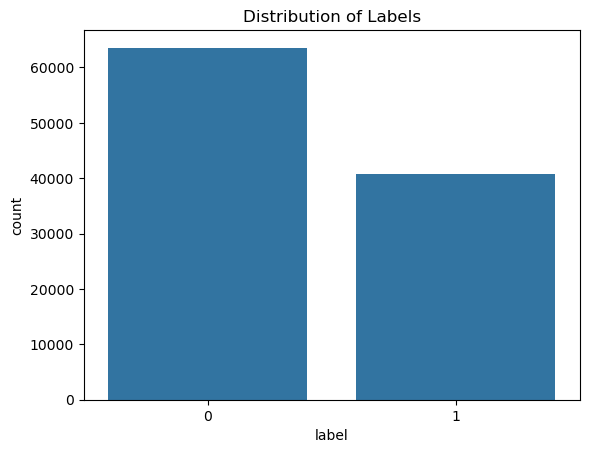

In [65]:
# Plot the distribution of the label
sns.countplot(x='label', data=data)
plt.title('Distribution of Labels')
plt.show()

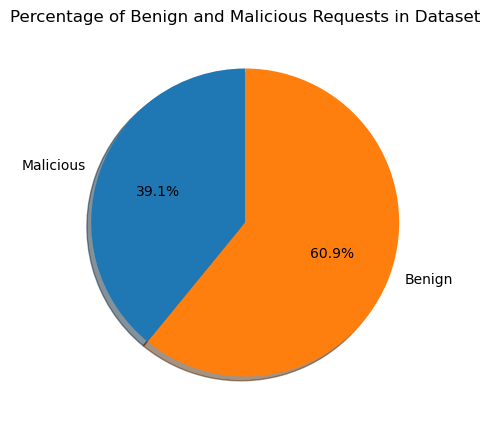

In [66]:
# Pie chart for label distribution
label_dict = dict(data['label'].value_counts())
labels = ["Malicious", "Benign"]
sizes = [label_dict[1], label_dict[0]]

plt.figure(figsize=(8, 5))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', shadow=True, startangle=90)
plt.title('Percentage of Benign and Malicious Requests in Dataset')
plt.show()

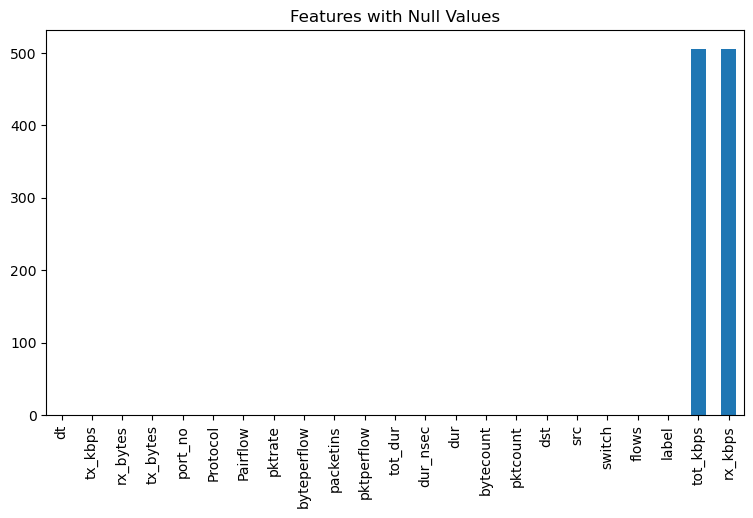

In [68]:
# Bar plot of missing values
plt.figure(figsize=(9, 5))
data.isna().sum().sort_values().plot.bar()
plt.title("Features with Null Values")
plt.show()

In [70]:
# Display dataset statistics
data.describe()

,dt,switch,pktcount,bytecount,dur,dur_nsec,tot_dur,flows,packetins,pktperflow,byteperflow,pktrate,Pairflow,port_no,tx_bytes,rx_bytes,tx_kbps,rx_kbps,tot_kbps,label
count,104345.000000,104345.000000,104345.000000,1.043450e+05,104345.000000,1.043450e+05,1.043450e+05,104345.000000,104345.000000,104345.000000,1.043450e+05,104345.000000,104345.000000,104345.000000,1.043450e+05,1.043450e+05,104345.000000,103839.000000,103839.000000,104345.000000
mean,17927.514169,4.214260,52860.954746,3.818660e+07,321.497398,4.613880e+08,3.218865e+11,5.654234,5200.383468,6381.715291,4.716150e+06,212.210676,0.600987,2.331094,9.325264e+07,9.328039e+07,998.899756,1003.811420,2007.578742,0.390857
std,11977.642655,1.956327,52023.241460,4.877748e+07,283.518232,2.770019e+08,2.834029e+11,2.950036,5257.001450,7404.777808,7.560116e+06,246.855123,0.489698,1.084333,1.519380e+08,1.330004e+08,2423.471618,2054.887034,3144.437173,0.487945
min,2488.000000,1.000000,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,2.000000,4.000000,-130933.000000,-1.464426e+08,-4365.000000,0.000000,1.000000,2.527000e+03,8.560000e+02,0.000000,0.000000,0.000000,0.000000
25%,7098.000000,3.000000,808.000000,7.957600e+04,127.000000,2.340000e+08,1.270000e+11,3.000000,1943.000000,29.000000,2.842000e+03,0.000000,0.000000,1.000000,4.743000e+03,3.539000e+03,0.000000,0.000000,0.000000,0.000000
50%,11905.000000,4.000000,42828.000000,6.471930e+06,251.000000,4.180000e+08,2.520000e+11,5.000000,3024.000000,8305.000000,5.521680e+05,276.000000,1.000000,2.000000,4.219610e+06,1.338339e+07,0.000000,0.000000,4.000000,0.000000
75%,29952.000000,5.000000,94796.000000,7.620354e+07,412.000000,7.030000e+08,4.130000e+11,7.000000,7462.000000,10017.000000,9.728112e+06,333.000000,1.000000,3.000000,1.356398e+08,1.439277e+08,251.000000,557.000000,3838.000000,1.000000
max,42935.000000,10.000000,260006.000000,1.471280e+08,1881.000000,9.990000e+08,1.880000e+12,17.000000,25224.000000,19190.000000,1.495387e+07,639.000000,1.000000,5.000000,1.269982e+09,9.905962e+08,20580.000000,16577.000000,20580.000000,1.000000


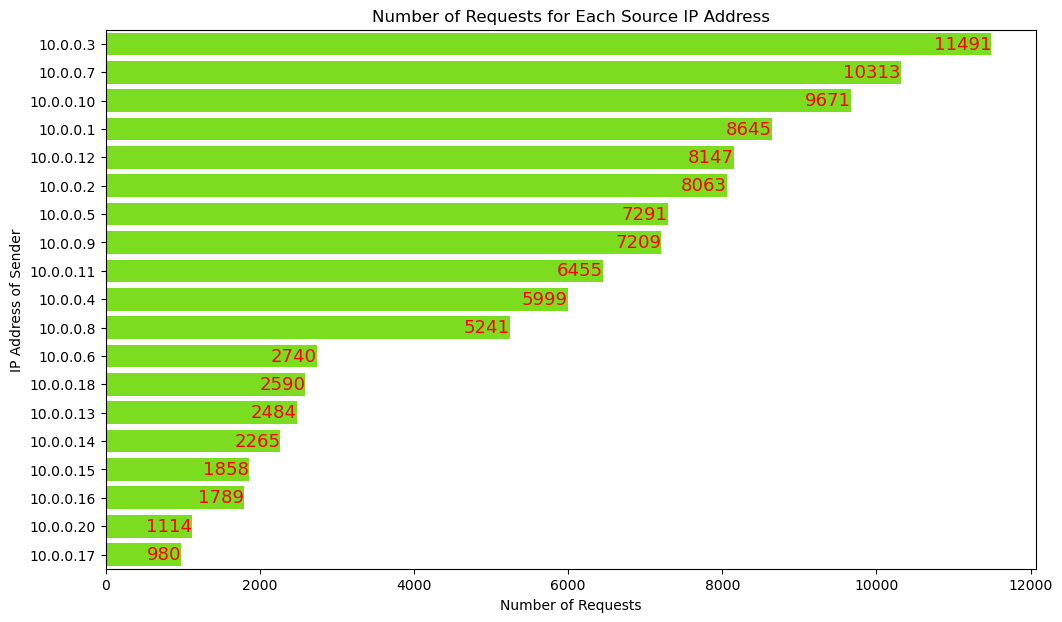

In [71]:
# Assuming 'src' is the column containing source IP addresses
plt.figure(figsize=(12, 7))
sns.countplot(y='src', data=data, color='lawngreen', order=data['src'].value_counts().index)

# Display the count values on the bars
for idx, count in enumerate(data['src'].value_counts()):
    plt.text(count, idx, str(count), ha='right', va='center', color='r', size=13)

plt.xlabel('Number of Requests')
plt.ylabel('IP Address of Sender')
plt.title('Number of Requests for Each Source IP Address')
plt.show()

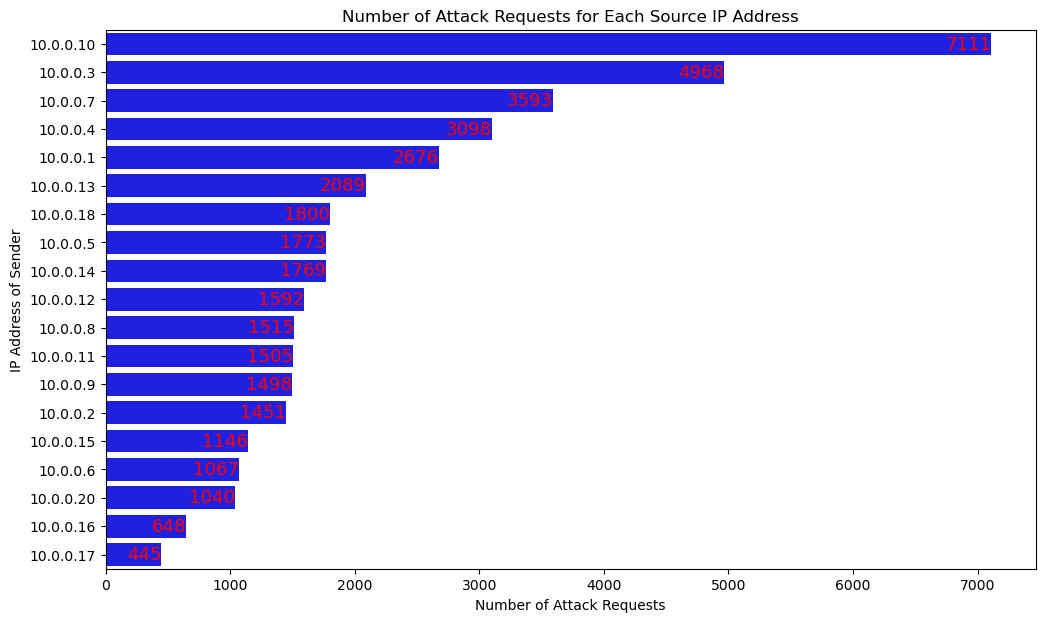

In [73]:
# Assuming 'src' is the column containing source IP addresses and 'label' is the column containing the attack labels
attack_data = data[data.label == 1]

plt.figure(figsize=(12, 7))
sns.countplot(y='src', data=attack_data, color='blue', order=attack_data['src'].value_counts().index)

# Display the count values on the bars
for idx, count in enumerate(attack_data['src'].value_counts()):
    plt.text(count, idx, str(count), ha='right', va='center', color='r', size=13)

plt.xlabel('Number of Attack Requests')
plt.ylabel('IP Address of Sender')
plt.title('Number of Attack Requests for Each Source IP Address')
plt.show()

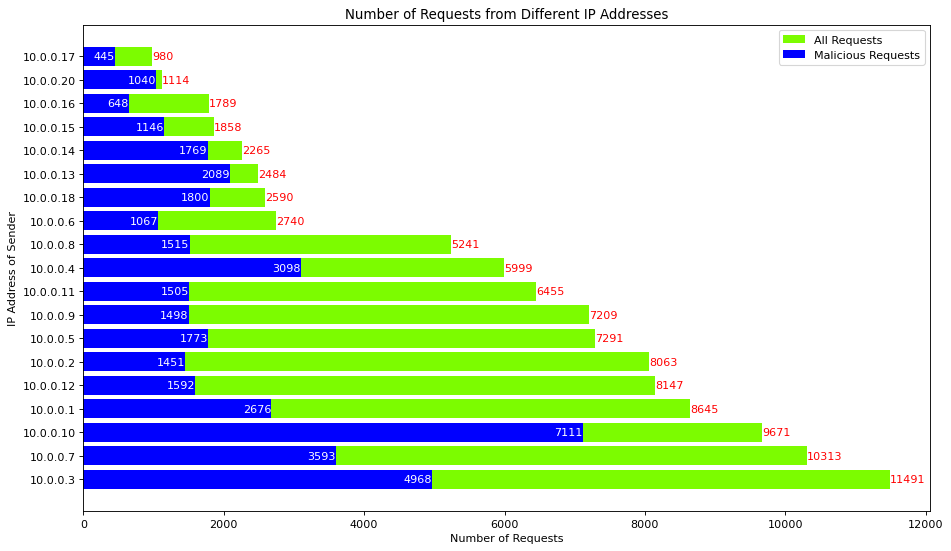

In [75]:
# Calculate request counts
all_requests = data['src'].value_counts()
malicious_requests = data[data['label'] == 1]['src'].value_counts()

# Plot all requests (green) and overlay malicious requests (blue)
plt.figure(figsize=(12, 7), dpi=80)
plt.barh(all_requests.index, all_requests.values, color='lawngreen', label='All Requests')
plt.barh(malicious_requests.index, malicious_requests.values, color='blue', label='Malicious Requests')

# Add text labels
for i, v in enumerate(all_requests.values):
    plt.text(v, i, str(v), color='r', va='center')
for i, v in enumerate(malicious_requests.reindex(all_requests.index, fill_value=0).values):
    if v > 0:
        plt.text(v, i, str(v), color='w', va='center', ha='right')

# Customize plot
plt.xlabel('Number of Requests')
plt.ylabel('IP Address of Sender')
plt.legend()
plt.title('Number of Requests from Different IP Addresses')
plt.tight_layout()
plt.show()

In [76]:
# Assuming your DataFrame is named 'df'
unique_protocols = data['Protocol'].value_counts()

# Display the unique protocols and their frequencies
print(unique_protocols)

Protocol
ICMP    41321
UDP     33588
TCP     29436
Name: count, dtype: int64


Text(0.5, 1.0, 'The number of requests from different protocols')

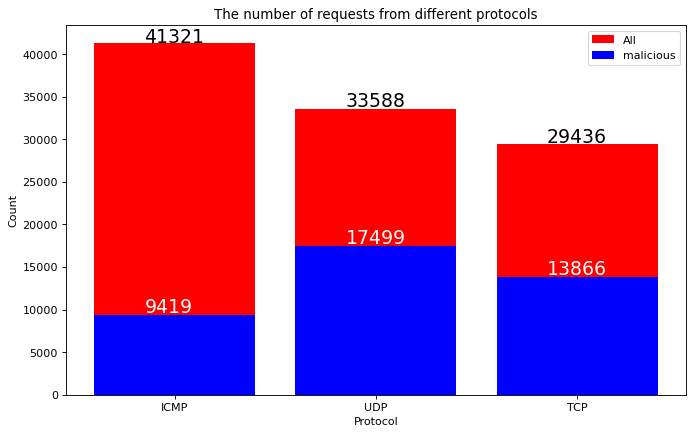

In [78]:
plt.figure(figsize=(10, 6), dpi=80)
plt.bar(list(dict(data.Protocol.value_counts()).keys()), dict(data.Protocol.value_counts()).values(), color='r')
plt.bar(list(dict(data[data.label == 1].Protocol.value_counts()).keys()), dict(data[data.label == 1].Protocol.value_counts()).values(), color='b')

plt.text(x = 0 - 0.15, y = 41321 + 00, s = str(41321), color='black', size=17)
plt.text(x = 1 - 0.15, y = 33588 + 200, s = str(33588), color='black', size=17)
plt.text(x = 2 - 0.15, y = 29436 + 200, s = str(29436), color='black', size=17)

plt.text(x = 0 - 0.15, y = 9419 + 200, s = str(9419), color='w', size=17)
plt.text(x = 1 - 0.15, y = 17499 + 200, s = str(17499), color='w', size=17)
plt.text(x = 2 - 0.15, y = 13866 + 200, s = str(13866), color='w', size=17)

plt.xlabel('Protocol')
plt.ylabel('Count')
plt.legend(['All', 'malicious'])
plt.title('The number of requests from different protocols')

 4.Feature Engineering

In [83]:
# Identify numeric and categorical columns
numeric_cols = data.select_dtypes(include=['int64', 'float64']).columns
object_cols = data.select_dtypes(include=['object']).columns

print('Numeric Columns:', numeric_cols)
print('Object Columns:', object_cols)

Numeric Columns: Index(['dt', 'switch', 'pktcount', 'bytecount', 'dur', 'dur_nsec', 'tot_dur',
       'flows', 'packetins', 'pktperflow', 'byteperflow', 'pktrate',
       'Pairflow', 'port_no', 'tx_bytes', 'rx_bytes', 'tx_kbps', 'rx_kbps',
       'tot_kbps', 'label'],
      dtype='object')
Object Columns: Index(['src', 'dst', 'Protocol'], dtype='object')


In [86]:
# Example of encoding object columns (src, dst, Protocol)
label_encoder = LabelEncoder()
data['src'] = label_encoder.fit_transform(data['src'])
data['dst'] = label_encoder.fit_transform(data['dst'])
data['Protocol'] = label_encoder.fit_transform(data['Protocol'])
print("Encoded Data:")
print(data)

Encoded Data:
           dt  switch  src  dst  pktcount  bytecount  dur   dur_nsec  \
0       11425       1    0   16     45304   48294064  100  716000000   
1       11605       1    0   16    126395  134737070  280  734000000   
2       11425       1   10   16     90333   96294978  200  744000000   
3       11425       1   10   16     90333   96294978  200  744000000   
4       11425       1   10   16     90333   96294978  200  744000000   
...       ...     ...  ...  ...       ...        ...  ...        ...   
104340   5262       3   14   15        79       7742   81  842000000   
104341   5262       3   14   15        79       7742   81  842000000   
104342   5262       3    2   13        31       3038   31  805000000   
104343   5262       3    2   13        31       3038   31  805000000   
104344   5262       3    2   13        31       3038   31  805000000   

             tot_dur  flows  ...  pktrate  Pairflow  Protocol  port_no  \
0       1.010000e+11      3  ...      451      

5.Data Preprocessing

In [89]:
# Define feature columns and target variable
feature_columns = ['switch', 'pktcount', 'bytecount', 'dur', 'Protocol', 'tx_bytes', 'rx_bytes', 'tx_kbps', 'rx_kbps']
X = data[feature_columns]
y = data['label']

In [91]:
# Handle missing values
imputer = SimpleImputer(strategy='mean')
X = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)

In [93]:
# Standardize the data
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [95]:
# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

6.Model Class

In [100]:
# Function to build a TensorFlow model
def build_tf_model(input_shape):
    model = Sequential([
        Dense(64, activation='relu', input_shape=(input_shape,)),
        Dropout(0.5),
        Dense(32, activation='relu'),
        Dropout(0.5),
        Dense(16, activation='relu'),
        Dense(3, activation='softmax')  # Assuming 3 classes, change to 2 if binary classification
    ])
    model.compile(optimizer='adam', 
                  loss='sparse_categorical_crossentropy', 
                  metrics=['accuracy'])
    return model

# Function to run models on different train-test splits
def run_multiple_splits(X, y, splits):
    metrics = {
        'model': [],
        'split': [],
        'accuracy': [],
        'precision': [],
        'recall': [],
        'f1-score': [],
        'time_taken': []
    }

    # List of models to evaluate
    models = {
        "Logistic Regression": LogisticRegression(C=0.03, solver='liblinear'),
        "Support Vector Machine": SVC(),
        "Decision Tree": DecisionTreeClassifier(),
        "Random Forest": RandomForestClassifier(),
        "K-Nearest Neighbors": KNeighborsClassifier(),
        "Neural Network (TensorFlow)": None  # Placeholder, we'll create this model later
    }

    # Iterate through each train-test split
    for split in splits:
        print(f"\nRunning for {split*100:.0f}-{(1-split)*100:.0f} train-test split:\n")

        # Split the data
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1-split, random_state=42)

        for model_name, model in models.items():
            start_time = time.time()

            # Check if we are running the TensorFlow model
            if model_name == "Neural Network (TensorFlow)":
                input_shape = X_train.shape[1]
                model = build_tf_model(input_shape)  # Build a new model for each split
                early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
                
                # Fit the TensorFlow model
                model.fit(X_train, y_train, epochs=20, batch_size=32, 
                          validation_split=0.2, callbacks=[early_stopping], verbose=0)
                
                # Predict and evaluate
                predictions = model.predict(X_test)
                predictions = predictions.argmax(axis=1)
            else:
                # Fit and predict with other models
                model.fit(X_train, y_train)
                predictions = model.predict(X_test)

            # Compute metrics
            accuracy = accuracy_score(y_test, predictions)
            report = classification_report(y_test, predictions, output_dict=True)
            weighted_avg = report['weighted avg']

            # Store metrics
            metrics['model'].append(model_name)
            metrics['split'].append(f"{split*100:.0f}-{(1-split)*100:.0f}")
            metrics['accuracy'].append(accuracy)
            metrics['precision'].append(weighted_avg['precision'])
            metrics['recall'].append(weighted_avg['recall'])
            metrics['f1-score'].append(weighted_avg['f1-score'])
            metrics['time_taken'].append(time.time() - start_time)

            # Display metrics for the current model
            print(f"Model: {model_name}")
            print(f"Accuracy: {accuracy:.4f}")
            print(f"Precision: {weighted_avg['precision']:.4f}")
            print(f"Recall: {weighted_avg['recall']:.4f}")
            print(f"F1-Score: {weighted_avg['f1-score']:.4f}")
            print(f"Time taken: {time.time() - start_time:.2f} seconds\n")
    
    return metrics

# Define the splits you want to test (90-10, 80-20, 70-30, and 60-40)
splits = [0.9, 0.8, 0.7, 0.6]

# Load the Iris dataset (or replace this with your actual dataset)
from sklearn.datasets import load_iris
data = load_iris()
X, y = data.data, data.target

# Call the function with your data
metrics = run_multiple_splits(X, y, splits)

# Convert metrics to DataFrame for better visualization
metrics_df = pd.DataFrame(metrics)

# Display the final table of metrics in a structured format
print("\nMetrics for Each Model:")
print("Split | Model                  | Accuracy | Precision | Recall | F1-Score | Time Taken")
print("------+-----------------------+----------+-----------+--------+----------+-----------")

for idx, row in metrics_df.iterrows():
    print(f"{row['split']:>5} | {row['model']:<22} | {row['accuracy']:.4f}   | {row['precision']:.4f}   | {row['recall']:.4f} | {row['f1-score']:.4f}  | {row['time_taken']:.2f} seconds")

# Calculate the average metrics for each model across all splits
average_metrics = metrics_df.groupby('model').mean(numeric_only=True)

# Display average metrics
print("\nAverage Metrics for Each Model:")
print("Model                  | Average Accuracy | Average Precision | Average Recall | Average F1-Score | Average Time Taken")
print("-----------------------+------------------+-------------------+----------------+-------------------+--------------------")

for model in average_metrics.index:
    row = average_metrics.loc[model]
    print(f"{model:<22} | {row['accuracy']:.4f}            | {row['precision']:.4f}             | {row['recall']:.4f}      | {row['f1-score']:.4f}         | {row['time_taken']:.2f} seconds")

# Find the best model based on the highest F1-score in the last split
best_model_idx = metrics_df[metrics_df['split'] == '60-40']['f1-score'].idxmax()
best_model = metrics_df.iloc[best_model_idx]
print(f"\nBest Model: {best_model['model']} with F1-Score: {best_model['f1-score']:.4f}") 



Running for 90-10 train-test split:

Model: Logistic Regression
Accuracy: 0.6000
Precision: 0.4667
Recall: 0.6000
F1-Score: 0.5000
Time taken: 0.01 seconds

Model: Support Vector Machine
Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F1-Score: 1.0000
Time taken: 0.01 seconds

Model: Decision Tree
Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F1-Score: 1.0000
Time taken: 0.01 seconds

Model: Random Forest
Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F1-Score: 1.0000
Time taken: 0.18 seconds



C:\Users\Kruthik\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Kruthik\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Kruthik\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Model: K-Nearest Neighbors
Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F1-Score: 1.0000
Time taken: 0.01 seconds



C:\Users\Kruthik\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
Model: Neural Network (TensorFlow)
Accuracy: 0.2000
Precision: 0.0400
Recall: 0.2000
F1-Score: 0.0667
Time taken: 2.67 seconds


Running for 80-20 train-test split:

Model: Logistic Regression
Accuracy: 0.7333
Precision: 0.8456
Recall: 0.7333
F1-Score: 0.6622
Time taken: 0.01 seconds

Model: Support Vector Machine
Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F1-Score: 1.0000
Time taken: 0.01 seconds

Model: Decision Tree
Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F1-Score: 1.0000
Time taken: 0.01 seconds

Model: Random Forest
Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F1-Score: 1.0000
Time taken: 0.14 seconds

Model: K-Nearest Neighbors
Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F1-Score: 1.0000
Time taken: 0.02 seconds



C:\Users\Kruthik\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Kruthik\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Kruthik\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Kruthik\anaconda3\Lib\sit

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
Model: Neural Network (TensorFlow)
Accuracy: 0.6333
Precision: 0.4683
Recall: 0.6333
F1-Score: 0.5195
Time taken: 3.15 seconds


Running for 70-30 train-test split:

Model: Logistic Regression
Accuracy: 0.6957
Precision: 0.5491
Recall: 0.6957
F1-Score: 0.5967
Time taken: 0.01 seconds

Model: Support Vector Machine
Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F1-Score: 1.0000
Time taken: 0.01 seconds

Model: Decision Tree
Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F1-Score: 1.0000
Time taken: 0.01 seconds

Model: Random Forest
Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F1-Score: 1.0000
Time taken: 0.12 seconds

Model: K-Nearest Neighbors
Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F1-Score: 1.0000
Time taken: 0.01 seconds



C:\Users\Kruthik\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Kruthik\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Kruthik\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Kruthik\anaconda3\Lib\sit

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
Model: Neural Network (TensorFlow)
Accuracy: 0.7174
Precision: 0.8587
Recall: 0.7174
F1-Score: 0.6420
Time taken: 3.52 seconds


Running for 60-40 train-test split:

Model: Logistic Regression
Accuracy: 0.6833
Precision: 0.5293
Recall: 0.6833
F1-Score: 0.5797
Time taken: 0.01 seconds

Model: Support Vector Machine
Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F1-Score: 1.0000
Time taken: 0.01 seconds

Model: Decision Tree
Accuracy: 0.9667
Precision: 0.9667
Recall: 0.9667
F1-Score: 0.9667
Time taken: 0.01 seconds

Model: Random Forest
Accuracy: 0.9833
Precision: 0.9842
Recall: 0.9833
F1-Score: 0.9833
Time taken: 0.15 seconds



C:\Users\Kruthik\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Kruthik\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Kruthik\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Model: K-Nearest Neighbors
Accuracy: 0.9833
Precision: 0.9842
Recall: 0.9833
F1-Score: 0.9833
Time taken: 0.01 seconds



C:\Users\Kruthik\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
Model: Neural Network (TensorFlow)
Accuracy: 0.5333
Precision: 0.3427
Recall: 0.5333
F1-Score: 0.4154
Time taken: 3.87 seconds


Metrics for Each Model:
Split | Model                  | Accuracy | Precision | Recall | F1-Score | Time Taken
------+-----------------------+----------+-----------+--------+----------+-----------
90-10 | Logistic Regression    | 0.6000   | 0.4667   | 0.6000 | 0.5000  | 0.01 seconds
90-10 | Support Vector Machine | 1.0000   | 1.0000   | 1.0000 | 1.0000  | 0.01 seconds
90-10 | Decision Tree          | 1.0000   | 1.0000   | 1.0000 | 1.0000  | 0.01 seconds
90-10 | Random Forest          | 1.0000   | 1.0000   | 1.0000 | 1.0000  | 0.18 seconds
90-10 | K-Nearest Neighbors    | 1.0000   | 1.0000   | 1.0000 | 1.0000  | 0.01 seconds
90-10 | Neural Network (TensorFlow) | 0.2000   | 0.0400   | 0.2000 | 0.0667  | 2.67 seconds
80-20 | Logistic Regression    | 0.7333   | 0.8456   | 0.7333 | 0.6622  | 0.01 seconds
80-20 | Support Vector

C:\Users\Kruthik\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Kruthik\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Kruthik\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


8.Statistical Analysis (Hypothesis Testing)

T-statistic: -139.78569354802218
P-value: 0.0
The difference in packet count between benign and malicious requests is statistically significant.


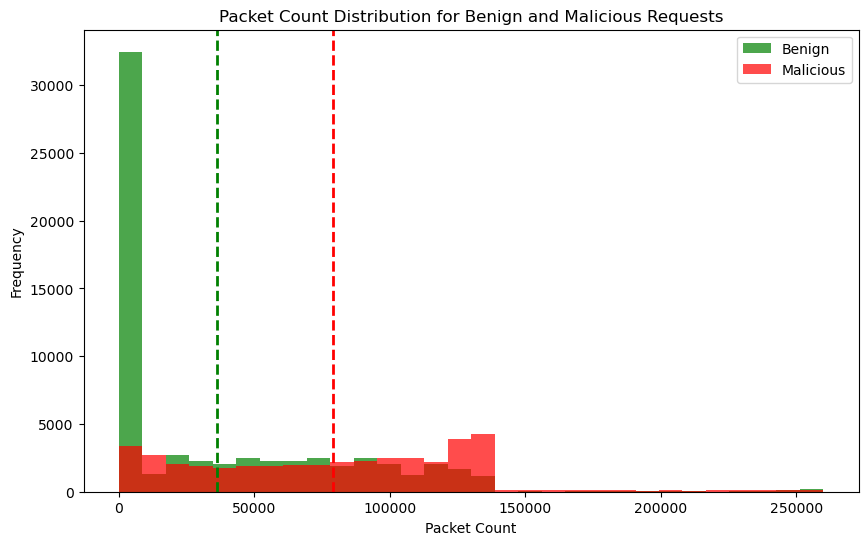

In [50]:
# Load dataset
data = pd.read_csv("DDOS comp final.csv")

# Separate data into two groups: Benign (label=0) and Malicious (label=1)
benign = data[data['label'] == 0]
malicious = data[data['label'] == 1]

# Extract the 'pktcount' feature for both groups
benign_pktcount = benign['pktcount'].dropna()
malicious_pktcount = malicious['pktcount'].dropna()

# Perform an independent t-test to compare the means of pktcount between benign and malicious requests
t_stat, p_value = stats.ttest_ind(benign_pktcount, malicious_pktcount, equal_var=False)

# Display results
print(f"T-statistic: {t_stat}")
print(f"P-value: {p_value}")

# Determine statistical significance at a 5% significance level
alpha = 0.05
if p_value < alpha:
    print("The difference in packet count between benign and malicious requests is statistically significant.")
else:
    print("The difference in packet count between benign and malicious requests is not statistically significant.")

# Visualization
plt.figure(figsize=(10, 6))
plt.hist(benign_pktcount, bins=30, alpha=0.7, label='Benign', color='green')
plt.hist(malicious_pktcount, bins=30, alpha=0.7, label='Malicious', color='red')
plt.title('Packet Count Distribution for Benign and Malicious Requests')
plt.xlabel('Packet Count')
plt.ylabel('Frequency')
plt.legend()
plt.axvline(benign_pktcount.mean(), color='green', linestyle='dashed', linewidth=2)
plt.axvline(malicious_pktcount.mean(), color='red', linestyle='dashed', linewidth=2)
plt.show()

9.anomalies detection

Total anomalies detected: 1935
Wanted anomalies: 1083
Unwanted anomalies: 852
Anomaly Threshold (wanted): 208965.93070034686
Anomaly Threshold (unwanted): 156904.521522057


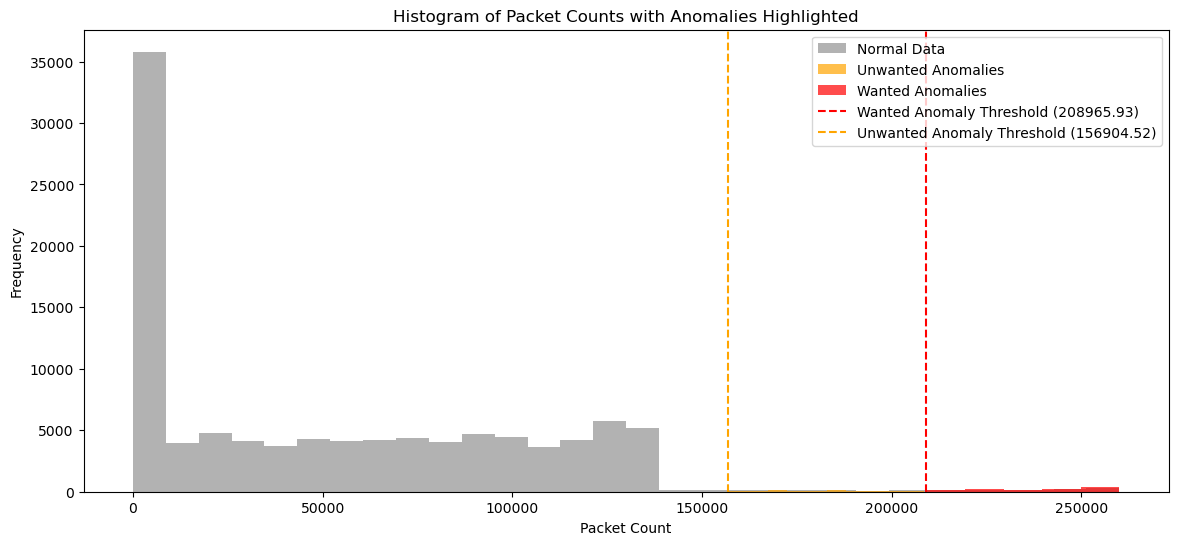

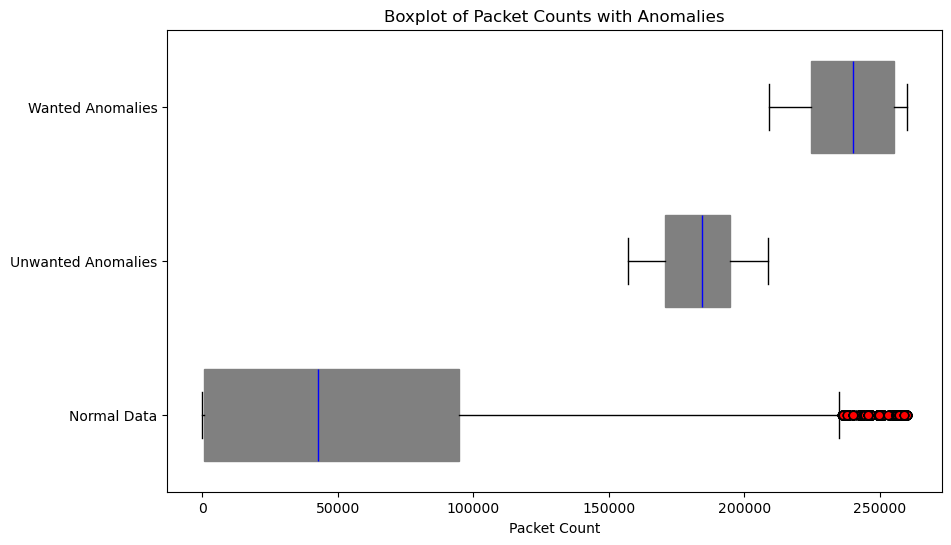

Malicious IPs detected: ['10.0.0.13' '10.0.0.4' '10.0.0.6' '10.0.0.10' '10.0.0.14' '10.0.0.15'
 '10.0.0.16' '10.0.0.17' '10.0.0.9' '10.0.0.11' '10.0.0.1' '10.0.0.7'
 '10.0.0.2' '10.0.0.5' '10.0.0.8']
Blocking IP: 10.0.0.13
Blocking IP: 10.0.0.4
Blocking IP: 10.0.0.6
Blocking IP: 10.0.0.10
Blocking IP: 10.0.0.14
Blocking IP: 10.0.0.15
Blocking IP: 10.0.0.16
Blocking IP: 10.0.0.17
Blocking IP: 10.0.0.9
Blocking IP: 10.0.0.11
Blocking IP: 10.0.0.1
Blocking IP: 10.0.0.7
Blocking IP: 10.0.0.2
Blocking IP: 10.0.0.5
Blocking IP: 10.0.0.8
Applying rate limit to IP: 10.0.0.13 with max 100 requests per minute.
Applying rate limit to IP: 10.0.0.4 with max 100 requests per minute.
Applying rate limit to IP: 10.0.0.6 with max 100 requests per minute.
Applying rate limit to IP: 10.0.0.10 with max 100 requests per minute.
Applying rate limit to IP: 10.0.0.14 with max 100 requests per minute.
Applying rate limit to IP: 10.0.0.15 with max 100 requests per minute.
Applying rate limit to IP: 10.0.0.16 wi

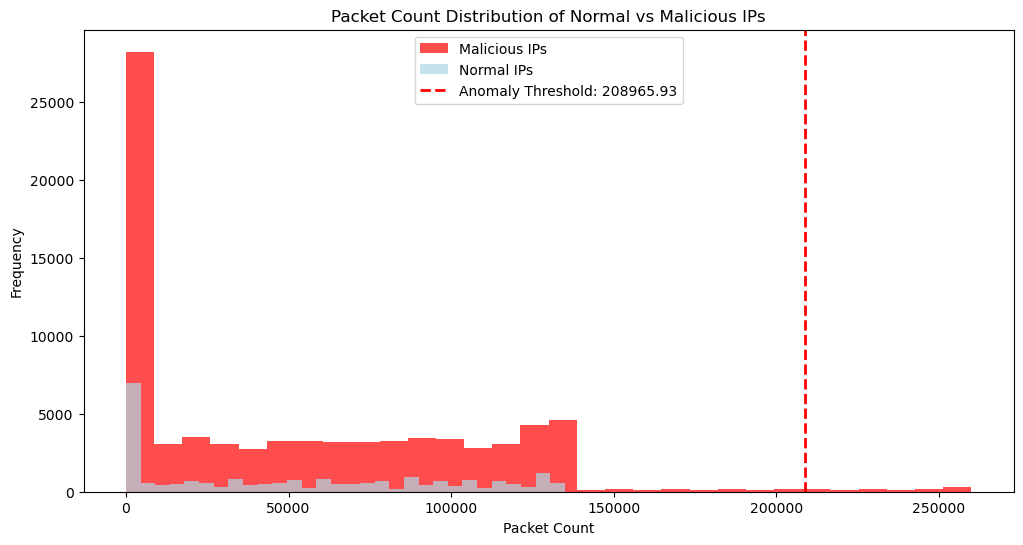

In [50]:
# Load the dataset
df = pd.read_csv("DDOS comp final.csv")

# Drop missing values (clean the data)
df = df.dropna()

# Define features and target variable
X = df.drop(['dt', 'src', 'dst', 'label'], axis=1)  # Drop unnecessary columns
y = df['label']

# Step 1: Calculate mean and standard deviation for packet count
mean_pktcount = X['pktcount'].mean()
std_pktcount = X['pktcount'].std()

# Step 2: Define the thresholds based on standard deviations
wanted_threshold = mean_pktcount + 3 * std_pktcount  # 3 standard deviations above the mean
unwanted_threshold = mean_pktcount + 2 * std_pktcount  # 2 standard deviations above the mean

# Step 3: Detect anomalies
wanted_anomalies = df[df['pktcount'] > wanted_threshold]  # Greater than 3 standard deviations
unwanted_anomalies = df[(df['pktcount'] > unwanted_threshold) & (df['pktcount'] <= wanted_threshold)]  # Between 2 and 3 standard deviations

# Print summary of anomalies
print(f"Total anomalies detected: {len(wanted_anomalies) + len(unwanted_anomalies)}")
print(f"Wanted anomalies: {len(wanted_anomalies)}")
print(f"Unwanted anomalies: {len(unwanted_anomalies)}")
print(f"Anomaly Threshold (wanted): {wanted_threshold}")
print(f"Anomaly Threshold (unwanted): {unwanted_threshold}")

# Visualize using Histogram
plt.figure(figsize=(14, 6))

# Histogram for all packet counts
plt.hist(df['pktcount'], bins=30, color='grey', alpha=0.6, label='Normal Data')

# Histogram for unwanted anomalies
plt.hist(unwanted_anomalies['pktcount'], bins=10, color='orange', alpha=0.7, label='Unwanted Anomalies')

# Histogram for wanted anomalies
plt.hist(wanted_anomalies['pktcount'], bins=5, color='red', alpha=0.7, label='Wanted Anomalies')

# Add vertical lines for thresholds
plt.axvline(wanted_threshold, color='red', linestyle='--', label=f'Wanted Anomaly Threshold ({wanted_threshold:.2f})')
plt.axvline(unwanted_threshold, color='orange', linestyle='--', label=f'Unwanted Anomaly Threshold ({unwanted_threshold:.2f})')

plt.title('Histogram of Packet Counts with Anomalies Highlighted')
plt.xlabel('Packet Count')
plt.ylabel('Frequency')
plt.legend()
plt.show()

# Visualize using Boxplot
plt.figure(figsize=(10, 6))

# Boxplot showing the distribution of pktcount
plt.boxplot([df['pktcount'], unwanted_anomalies['pktcount'], wanted_anomalies['pktcount']],
            vert=False, widths=0.6,
            patch_artist=True, 
            boxprops=dict(facecolor='grey', color='grey'),
            flierprops=dict(markerfacecolor='red', marker='o'),
            medianprops=dict(color='blue'))

plt.yticks([1, 2, 3], ['Normal Data', 'Unwanted Anomalies', 'Wanted Anomalies'])
plt.xlabel('Packet Count')
plt.title('Boxplot of Packet Counts with Anomalies')
plt.show()

# Step 4: Block malicious IP addresses (for prevention)
malicious_ips = df[df['pktcount'] > wanted_threshold]['src'].unique()

print(f"Malicious IPs detected: {malicious_ips}")

# Simulate blocking IP addresses (In real-world, use firewall or network tools)
def block_ips(ips):
    for ip in ips:
        print(f"Blocking IP: {ip}")  # You can replace this with actual firewall commands like iptables

# Block detected malicious IPs
block_ips(malicious_ips)

# Example of rate-limiting prevention (if applicable to your network setup):
def rate_limit_ip(ip, max_requests_per_minute=100):
    print(f"Applying rate limit to IP: {ip} with max {max_requests_per_minute} requests per minute.")
    # Here you would integrate with a rate-limiting tool (e.g., Cloudflare, iptables, NGINX, etc.)

# Apply rate-limiting to detected malicious IPs
for ip in malicious_ips:
    rate_limit_ip(ip)

# Geo-Blocking: Block traffic from specific countries/regions
# Example: Assuming you have the country information for each IP (could use GeoIP libraries or external APIs)
def geo_block_ips(ips, countries_to_block=['US', 'CN']):
    print("Geo-blocking IPs from countries:", countries_to_block)
    for ip in ips:
        # Here you would use a service like GeoIP to check the country of the IP
        # For demonstration, we are assuming that IPs in the 'malicious_ips' list are from blocked countries.
        # In practice, use a library like geoip2 or a service like MaxMind.
        country = "US"  # Placeholder, replace with actual lookup logic
        if country in countries_to_block:
            print(f"Blocking IP {ip} from country {country}")
            os.system(f"iptables -A INPUT -s {ip} -j DROP")  # Block by IP for demonstration

geo_block_ips(malicious_ips)

# Traffic Shaping: Redirect traffic that exceeds a threshold to a slower route
def traffic_shaping(ip):
    print(f"Shaping traffic for IP: {ip}")
    # Simulate traffic shaping by rerouting the IP to a slower server or limiting bandwidth
    # This can be implemented using tools like HAProxy or network policies
    time.sleep(2)  # Simulate slower traffic for the given IP (blocking access for 2 seconds)

# Apply traffic shaping to detected malicious IPs
for ip in malicious_ips:
    traffic_shaping(ip)

# WAF (Web Application Firewall) Rules: Apply security rules to filter malicious requests
def apply_waf_rules():
    print("Applying WAF rules to filter malicious requests.")
    # Example: You can integrate this with a WAF tool like AWS WAF, ModSecurity, or NGINX WAF
    # Here, we simulate applying a basic rule to block high-volume packet count requests.
    # In practice, these rules would be based on URL patterns, request headers, and other factors.

apply_waf_rules()

# Example: Add to persistent blacklist
def add_to_blacklist(ips):
    print("Adding malicious IPs to blacklist:")
    # This would typically involve adding the IPs to a database or a persistent file for future reference.
    with open('blacklist.txt', 'a') as file:
        for ip in ips:
            file.write(f"{ip}\n")
            print(f"IP {ip} added to blacklist.")

# Add malicious IPs to blacklist
add_to_blacklist(malicious_ips)

# Visualization: Show malicious IPs over packet counts
plt.figure(figsize=(12, 6))

# Plot the packet counts of malicious IPs
plt.hist(df[df['src'].isin(malicious_ips)]['pktcount'], bins=30, color='red', alpha=0.7, label='Malicious IPs')

# Plot the packet counts of normal traffic (not malicious)
plt.hist(df[~df['src'].isin(malicious_ips)]['pktcount'], bins=30, color='lightblue', alpha=0.7, label='Normal IPs')

plt.axvline(wanted_threshold, color='red', linestyle='dashed', linewidth=2, label=f'Anomaly Threshold: {wanted_threshold:.2f}')
plt.title('Packet Count Distribution of Normal vs Malicious IPs')
plt.xlabel('Packet Count')
plt.ylabel('Frequency')
plt.legend()
plt.show()
